In [54]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import rasterio.sample 
from rasterio.plot import reshape_as_raster, reshape_as_image
from pyproj import Transformer
import pandas as pd

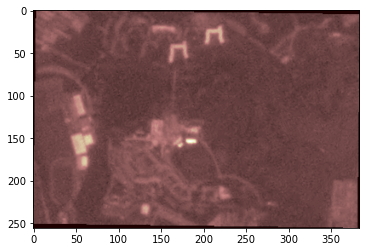

In [2]:
src = rasterio.open('C:/Users/daa5/OneDrive - University of Stirling/PlanetData/\
airthrey-18-20-jun-22-SurfaceReflectance_psscene_analytic_8b_sr_udm2/files/\
20220620_102924_31_2423_3B_AnalyticMS_SR_8b_clip.tif')

src1 = rasterio.open('C:/Users/daa5/OneDrive - University of Stirling/PlanetData/\
airthrey-18-20-jun-22-SurfaceReflectance_psscene_analytic_8b_sr_udm2/files/\
20220618_105818_44_249a_3B_AnalyticMS_SR_8b_clip.tif')

array = src1.read(1)
plt.imshow(array, cmap='pink')
plt.show()

92 88
91 157


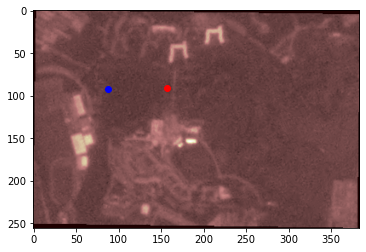

In [23]:
src1.crs
inProj = Proj('WGS 84')
outProj = Proj('epsg:32630')
transformer = Transformer.from_crs('WGS 84', 'epsg:32630')
lat_jetty, lon_jetty = 56.14720916748047, -3.92333722114563
lat_bridge, lon_bridge = 56.14725875854492, -3.920006513595581

jetty_x,jetty_y = transformer.transform(lat_jetty, lon_jetty)
bridge_x,bridge_y = transformer.transform(lat_bridge, lon_bridge)

jetty_row, jetty_col = src1.index(jetty_x, jetty_y)
print(jetty_row, jetty_col)
bridge_row,bridge_col = src1.index(bridge_x, bridge_y)
print(bridge_row,bridge_col)

array = src1.read()
plt.imshow(array, cmap='pink')
plt.scatter(jetty_col, jetty_row, marker='o', color='blue')
plt.scatter(bridge_col, bridge_row, marker='o', color='red')

plt.show()


,Band Name,Wavelength,0,1,2,3,4,5,6,7,8
0,coastal_blue,443,0.006195,0.005219,0.005127,0.006348,0.005295,0.004959,0.006348,0.006027,0.005402
1,blue,490,0.004929,0.005096,0.005356,0.004669,0.005096,0.005096,0.004578,0.004593,0.004532
2,green_i,531,0.005432,0.005569,0.005569,0.005005,0.005417,0.005661,0.005295,0.005661,0.005692
3,green,565,0.006027,0.005524,0.005936,0.005844,0.005646,0.005920,0.005920,0.005829,0.005753
4,yellow,610,0.005386,0.006073,0.005844,0.005310,0.005646,0.005432,0.005646,0.005569,0.005066
5,red,665,0.003723,0.004471,0.004929,0.003586,0.004501,0.004700,0.004471,0.004913,0.004684
6,rededge,705,0.007599,0.006027,0.005966,0.007629,0.005936,0.006058,0.004395,0.005280,0.006851
7,nir,865,0.012970,0.011963,0.011642,0.011429,0.011826,0.011566,0.010223,0.011459,0.011200


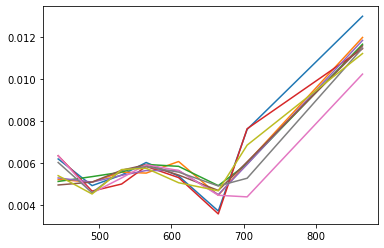

In [115]:
def getSpectraFromSDSR(rasterFile, xx, yy, crs_SD='epsg:32630', crs_coords= 'WGS 84'):
    '''
    - takes a filename to a superdoves surface reflectance tif file and xx, yy coords as inputs
    xx, yy can be lists, arrays or scalars
    - returns a pandas df with columns for each coord and the SD wavelengths
    - default: take input coords in WGS 84 format (N, W: eg. 56.147209, -3.923337) and then index the tif using epsg:32630
    but this can be changed where needed (eg. if looking at data outside UK then epsg:32630 might not be appropriate)
    CRS must be specified in the pyproj string format 
    '''
    transformer = Transformer.from_crs(crs_coords, crs_SD)
    xxT, yyT = transformer.transform(xx, yy)
    with rasterio.open(rasterFile) as dataset:
        try:
            spect = rasterio.sample.sample_gen(dataset, zip(xxT, yyT))
        except TypeError:
            spect = rasterio.sample.sample_gen(dataset, zip([xxT], [yyT]))
        wavelengths = pd.DataFrame(data={'Band Name':dataset.descriptions,
                                         'Wavelength':[443, 490, 531, 565, 610, 665, 705, 865]})
        data = np.array(list(spect)).T/(2**16)
    df = pd.DataFrame(data=data)
    df = wavelengths.join(df)
    return df

def getSpectraFromSDSR_grid(rasterFile, x, y, shape=(3, 3), crs_SD='epsg:32630', crs_coords= 'WGS 84'):
    '''
    generates grid with shape = shape around the coord (x, y) of interest (default crs for coord WGS84)
    returns spectra for each coord in pandas df
    '''
    transformer = Transformer.from_crs(crs_coords, crs_SD)
    xxT, yyT = transformer.transform(x, y)
    
    with rasterio.open(rasterFile) as dataset:
        row, col = dataset.index(xxT, yyT)
        # generate x and y coords for grid with shape=(shape[0], shape[1])
        rows = np.linspace(row - shape[0]//2,
                        row + shape[0]//2 - (1 - shape[0]%2),
                        shape[0],
                        dtype=int)
        cols = np.linspace(col - shape[1]//2,
                        col + shape[1]//2 - (1 - shape[1]%2),
                        shape[1],
                        dtype=int)
      
        inds = (np.tile(rows, len(cols)), np.repeat(cols, len(rows)))
        spect = dataset.read()[np.index_exp[:] + inds]
        wavelengths = pd.DataFrame(data={'Band Name':dataset.descriptions,
                                         'Wavelength':[443, 490, 531, 565, 610, 665, 705, 865]})
        
        data = np.array(list(spect))/(2**16)
        
    df = pd.DataFrame(data=data)
    df = wavelengths.join(df)
    return df

xx = [56.14720916748047, 56.14725875854492]
yy = [-3.92333722114563, -3.920006513595581]

spects = getSpectraFromSDSR('C:/Users/daa5/OneDrive - University of Stirling/PlanetData/\
airthrey-18-20-jun-22-SurfaceReflectance_psscene_analytic_8b_sr_udm2/files/\
20220618_105818_44_249a_3B_AnalyticMS_SR_8b_clip.tif', xx, yy)

spects = getSpectraFromSDSR_grid('C:/Users/daa5/OneDrive - University of Stirling/PlanetData/\
airthrey-18-20-jun-22-SurfaceReflectance_psscene_analytic_8b_sr_udm2/files/\
20220618_105818_44_249a_3B_AnalyticMS_SR_8b_clip.tif', xx[0], yy[0])

for i in range(9):
    plt.plot(spects['Wavelength'], spects[i])
spects

In [100]:
xx,yy = transformer.transform([lat_jetty, lat_bridge], [lon_jetty, lon_bridge])
spect = rasterio.sample.sample_gen(src1, zip(xx, yy))
#list(spect)
#df = pd.DataFrame(data=list(spect))
#list(spect)
wavelengths = pd.DataFrame(data={'Band Name':src1.descriptions,
                                 'Wavelength':[443, 490, 531, 565, 610, 665, 705, 865]})
data = np.array(list(spect)).T
df = pd.DataFrame(data=data)
wavelengths.join(df)

ar = src1.read()
ar.shape

(8, 256, 384)

In [105]:
a = np.array([[1, 2, 3], [2, 5, 7]])
inds = [(0, 0), (1, 1), (1, 0)]
inds_array = np.moveaxis(np.array(inds), -1, 0)

tuple(inds_array)

(array([0, 1, 1]), array([0, 1, 0]))

('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir')

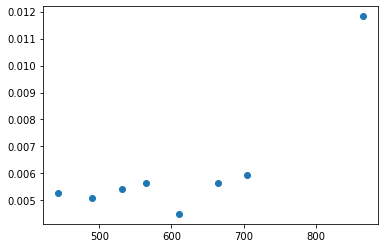

In [81]:
jetty_spectra = (np.array(list(rasterio.sample.sample_gen(src1, [(jetty_x,jetty_y)])))/2**16).reshape((8,))
plt.plot([443, 490, 531, 565, 665, 610, 705, 865], jetty_spectra, 'o')
src1.descriptions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 384, 3)


1.0

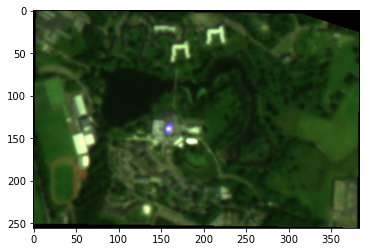

In [158]:
data = src.read()
image = reshape_as_image(data)
print(image[:, :, 2::2].shape)

image = np.flip(image[:, :, 1:6:2], 2).astype(np.float64)
for i in range(3):
    image[:, :, i] = (image[:, :, i] - image[:, :, i].min()) / (image[:, :, i].max() - image[:, :, i].min())

plt.imshow(image*2)
image.max()
#image[:, :, 1:6:2].shape

In [ ]:
data = src1.read()
image = reshape_as_image(data)
print(image[:, :, 2::2].shape)

image.shape

In [ ]:
plt.imshow(image[:, :, 2::2])

In [ ]:
for i in range(data.shape[1]):
    for j in range(data.shape[2]):
        plt.plot(data[:, i, j]/((2**16)), 'o-')

In [ ]:
# this is actually really important code!! - using LineCollection makes plotting lots of lines way way faster! 

segs = data.reshape((data.shape[0], data.shape[1]* data.shape[2])).T.astype(np.float64)/(2**16)
x = np.arange(8)
x2 = np.broadcast_to(x, (segs.shape[0], 8))

segs = np.stack([x2, segs], axis=2)
segs.shape

In [ ]:
from matplotlib.collections import LineCollection
line_segments = LineCollection(segs, alpha=0.002)
fig, ax = plt.subplots()
ax.add_collection(line_segments)
ax.set_ylim(0, 0.3)
ax.set_xlim(0, 10)

plt.show()

In [ ]:
np.max(segs)

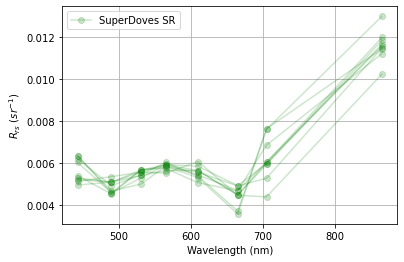

In [160]:
def plotSDRasterSpectraGrid(rasterFile, x, y, ax=None, shape=(3, 3), crs_SD='epsg:32630', crs_coords= 'WGS 84', plotShow=False):
    '''
    plots spectra from superdoves raster file for a grid of pixels, shape=shape, at a given x, y point
    (default CRS is WGS84, but can change using crs_coords)
    '''
    df = getSpectraFromSDSR_grid(rasterFile, x, y, shape=(3, 3), crs_SD='epsg:32630', crs_coords= 'WGS 84')
    
    if ax is None:
        ax = plt.gca()
    
    for col in list(df.columns.values)[2:]:
        ax.plot(df['Wavelength'],
                 df[col],
                 color='green',
                 label='SuperDoves SR',
                 marker='o',
                 alpha=0.2)
        
    handles, labels = ax.get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    ax.legend(newHandles, newLabels)
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')    
    ax.grid()
    if plotShow:
        plt.show()
        

plotSDRasterSpectraGrid('C:/Users/daa5/OneDrive - University of Stirling/PlanetData/\
airthrey-18-20-jun-22-SurfaceReflectance_psscene_analytic_8b_sr_udm2/files/\
20220618_105818_44_249a_3B_AnalyticMS_SR_8b_clip.tif', xx[0], yy[0])   
